# Image Jigsaw Puzzle SSL on CIFAR10 dataset 

Author: Tanish Phopalkar  

Implementation of the Image Jigsaw Puzzle as mentioned in this paper [Unsupervised Learning of Visual
 Representations by Solving Jigsaw Puzzles](https://arxiv.org/abs/1603.09246v3)
 
Here I have implemented the Jigsaw Puzzle SSL with EffecientNet as Siamese Covolutional layers and trained it on 45% of data as a pretraining. Then the weights of the this pretrained model is transferred to a EffecientNet classifier and the last fc layer is trained on 5% of the dataset for fine tuning. We will also be analyzing the models, one pretrained on labeled images and other pretrained using Image Jigsaw Puzzle.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torchvision
import torch
import timm
import random
from PIL import Image
from IPython.display import display


C:\Users\Admin\.conda\envs\neural_ODE\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
#defining file paths
PATH = os.curdir

cfn_file = os.path.join(PATH, 'saved_cfn.pth')
conv_file = os.path.join(PATH,'saved_conv2.pth')
jigsaw_model_file = os.path.join(PATH, 'saved_jigsaw_model.pth')
permuts_file = os.path.join(PATH, 'permuts.npy')

cfn_file

'.\\saved_cfn.pth'

Downloading the data from torchvision dateset

In [4]:
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision import datasets, transforms


Image_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True)

test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True)

Image_dataset =  ConcatDataset([Image_dataset, test_set])

train_dataset, pretrain_dataset, test_dataset = random_split(Image_dataset, [0.05, 0.45, 0.5])

Files already downloaded and verified
Files already downloaded and verified


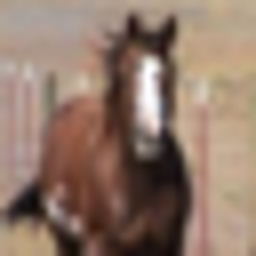

horse


In [5]:
img, label = pretrain_dataset.__getitem__(0)
img = img.resize((256,256))


label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
display(img)
print(label_names[label])

Defining some useful functions

In [6]:
def get_nine_crops(pil_image):
    """
    taken from https://github.com/aniket03/self_supervised_bird_classification/blob/master/get_dataset.py
    
    Get nine crops for a square pillow image. That is height and width of the image should be same.
    :param pil_image: pillow image
    :return: List of pillow images. The nine crops
    """
    w, h = pil_image.size
    diff = int(w/3)

    r_vals = [0, diff, 2 * diff]
    c_vals = [0, diff, 2 * diff]

    list_patches = []

    for r in r_vals:
        for c in c_vals:

            left = c
            top = r
            right = c + diff
            bottom = r + diff

            patch = pil_image.crop((left, top, right, bottom))
            list_patches.append(patch)

    return list_patches

def rearrange(nine_crop, permut):
    X= nine_crop
    Y= permut
    sorted_indices = sorted(range(len(Y)), key=lambda k: Y[k])
    reordered_crops = [X[i] for i in sorted_indices]
    return reordered_crops

def generate_permuts(array_len = 9, permuts_to_take= 64):
    
    #https://github.com/aniket03/self_supervised_bird_classification/blob/master/get_top_x_permutations.py
    import itertools
    import random
    import numpy as np

    from scipy.spatial.distance import hamming


    # Build list of all possible permutations
    permuts_list = list(itertools.permutations(range(array_len)))
    permuts_array = np.array(permuts_list)
    no_permuts = len(permuts_list)


    # Take top x permutations which have max average hamming distance
    set_of_taken = set()
    cnt_iterations = 0
    while True:
        cnt_iterations += 1
        x = random.randint(1, no_permuts - 1)
        y = random.randint(1, no_permuts - 1)
        permut_1 = permuts_array[x]
        permut_2 = permuts_array[y]
        hd = hamming(permut_1, permut_2)

        if hd > 0.9 and (not x in set_of_taken) and (not y in set_of_taken):
            set_of_taken.add(x)
            set_of_taken.add(y)

            if len(set_of_taken) == permuts_to_take:
                break

        if cnt_iterations % 100 == 0:
            print ("Already performed count of iterations with pairs of jigsaw permutations", cnt_iterations)
            print ("Length of set of taken: ",len(set_of_taken))

    print ("No of iterations it took to build top - {} permutations array = {}".format(permuts_to_take, cnt_iterations))
    print ("No of permutations", len(set_of_taken))


    # Build the array for selected permutation indices above
    selected_permuts = []
    for ind, perm_id in enumerate(set_of_taken):
#         if ind < 10:
#             print ("Sample permutation {}".format(ind))
#             print (permuts_array[perm_id])
        selected_permuts.append(permuts_array[perm_id])

    selected_permuts = np.array(selected_permuts)
#     np.save('selected_permuts.npy', selected_permuts)

    return selected_permuts

generating the list of permutations and storing in npy file

In [7]:
#generating 64 possible permuts
nine_crops = get_nine_crops(img)
permuts = generate_permuts()
classes, _ = permuts.shape

Already performed count of iterations with pairs of jigsaw permutations 100
Length of set of taken:  62
No of iterations it took to build top - 64 permutations array = 101
No of permutations 64


In [8]:
#saving and loading permuts
np.save( permuts_file, permuts)
permuts = np.load(permuts_file)

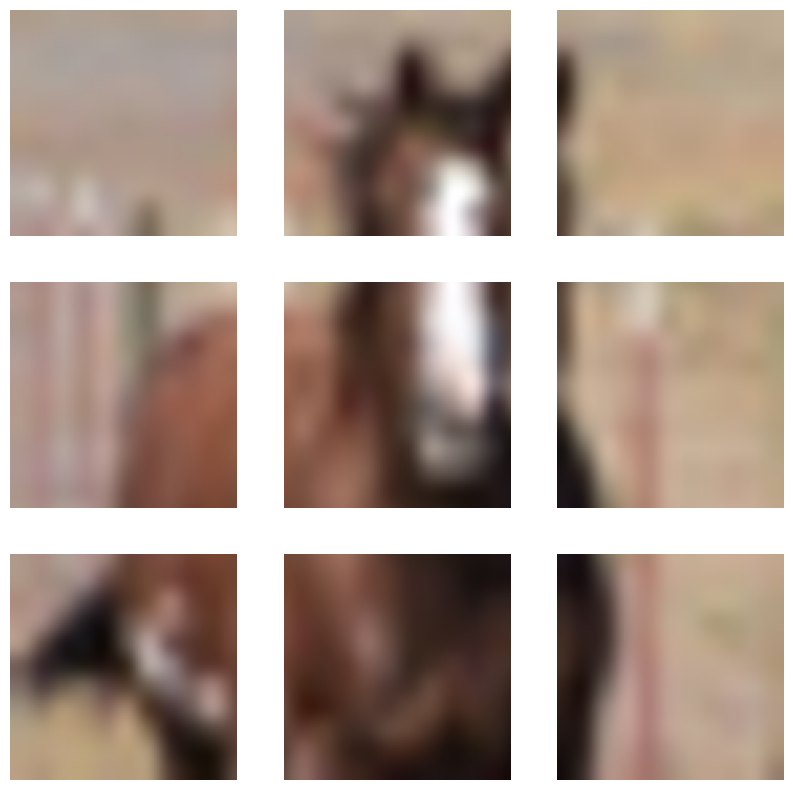

horse


In [9]:
#before shuffling

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

rows = 3
cols = 3
figsize=(10, 10)

fig, axes = plt.subplots(rows, cols, figsize=figsize)

for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]
        ax.axis("off")

        # Check if there are more images to display
        index = i * cols + j
        if index < len(nine_crops):
            ax.imshow(np.asarray(nine_crops[index]))


plt.show()
print(label_names[label])

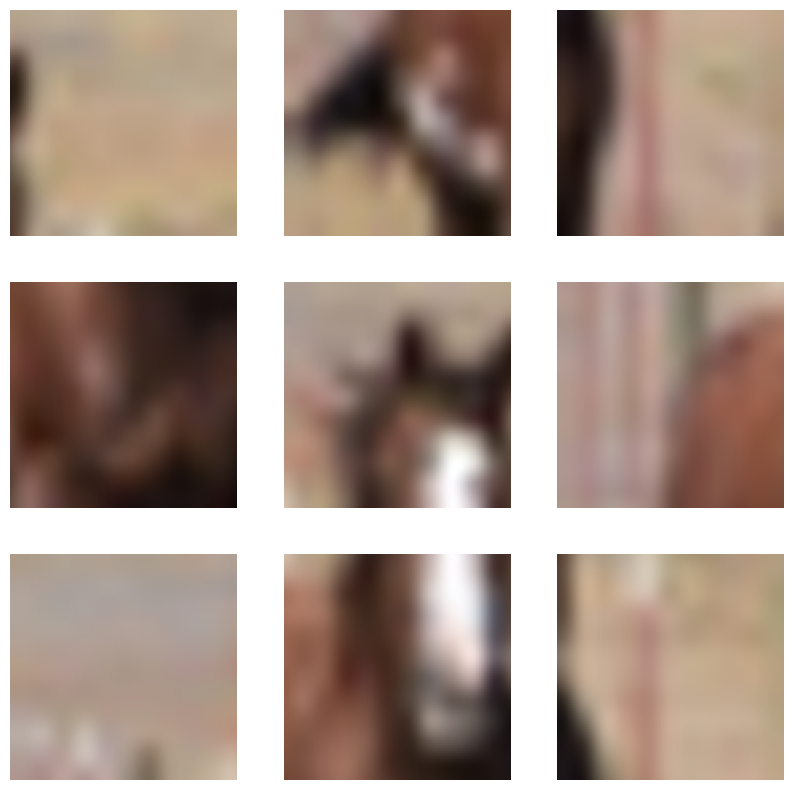

'horse'

In [10]:
#after shuffling
nine_crops = rearrange(nine_crops, permuts[0])

fig, axes = plt.subplots(rows, cols, figsize=figsize)

for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]
        ax.axis("off")

        # Check if there are more images to display
        index = i * cols + j
        if index < len(nine_crops):
            ax.imshow(np.asarray(nine_crops[index]))


plt.show()
label_names[label]

## Pretraining

Creating a datset for pretraining. Here 20 jigsaw puzzles are created per image (69 in the paper but training take much longer). The shuffling pattern is taken from a fixed set of permutations. The model has to classify the shuffled image into one of these 64 posssible permuations.

In [43]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class JigsawDataset(Dataset):
    def __init__(self, dataset, permuts, no_of_jigs):  #permuts is the list of permuation set      
        self.dataset = dataset
        self.permuts = permuts
        self.no_of_jigs = no_of_jigs 
        self.mean_values = [0.485, 0.456, 0.406]
        self.std_values = [0.229, 0.224, 0.225]


    def __len__(self):
        return self.dataset.__len__() * self.no_of_jigs # 20 jigsaw puzzles per images
    
    def __getitem__(self, index):
        index = int(index / self.no_of_jigs)
        img, _ = self.dataset.__getitem__(index)
        
        nine_crops = get_nine_crops(img)
        
        r = random.randint(0, len(permuts) -1 )
        nine_crops = rearrange(nine_crops, permuts[r])

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean_values, std=self.std_values)
        ])
        
        image_list = []
        for i in range(9):
            #print(transform(nine_crops[i]).shape)
            #image_list = torch.concat((image_list, transform([nine_crops[i]])), dim = 0)
            image_list.append(transform(nine_crops[i]))
        
        image_list = torch.stack(image_list, dim = 0)
        return image_list, r
    


In [14]:
Jig_Dataset =  JigsawDataset(pretrain_dataset, permuts, no_of_jigs= 20)
# Jig_Dataset.__len__()
#Jig_Dataset.__getitem__(2)

pretrain_loader = DataLoader(Jig_Dataset, batch_size = 128, shuffle =True)


## CFN Model

In the paper, they have used AlexNet for CFN. The CFN is a siamese-ennead CNN. Here we will be using EffecientNet-b0 for CFN plus 3 fully connected layers with relu activation.

In [15]:
import torch
import torch.nn as nn
from torch import cat
import torch.nn.init as init

#code taken from: https://github.com/bbrattoli/JigsawPuzzlePytorch/blob/master/JigsawNetwork.py

class Network(nn.Module):

    def __init__(self, classes=64):
        super(Network, self).__init__()

        self.conv = timm.create_model('efficientnet_b0', pretrained=False)  # Set pretrained to False
        self.conv = nn.Sequential(*(list(self.conv.children())[:-1]))
        
        self.fc6 = nn.Sequential()
        self.fc6.add_module('fc6_s1',nn.Linear(1280, 1024)) #256*3*3
        self.fc6.add_module('relu6_s1',nn.ReLU(inplace=True))
        self.fc6.add_module('drop6_s1',nn.Dropout(p=0.5))

        self.fc7 = nn.Sequential()
        self.fc7.add_module('fc7',nn.Linear(9*1024,4096))
        self.fc7.add_module('relu7',nn.ReLU(inplace=True))
        self.fc7.add_module('drop7',nn.Dropout(p=0.5))

        self.classifier = nn.Sequential()
        self.classifier.add_module('fc8',nn.Linear(4096, classes))
        
        #self.apply(weights_init)

    def load(self,checkpoint):
        model_dict = torch.load(checkpoint)
        self.load_state_dict(model_dict)

    def save(self,checkpoint):
        torch.save(self.state_dict(), checkpoint)
        
    def save_conv(self,checkpoint):                    
        torch.save(self.conv.state_dict(), checkpoint)   #to save only the convolutional weights
    
    def forward(self, x):
        B,T,C,H,W = x.size()
        x = x.transpose(0,1)

        x_list = []
        for i in range(9):
            z = self.conv(x[i])
            z = self.fc6(z.view(B,-1))
            z = z.view([B,1,-1])
            x_list.append(z)

        x = cat(x_list,1)
        x = self.fc7(x.view(B,-1))
        x = self.classifier(x)

        return x


In [16]:
CFN = Network()
#CFN.load_state_dict(torch.load(cfn_file))

### Pre-training
Here we train the model for only 1 epoch. The weights in the saved file are run for 4 epochs.

In [17]:
import torch.optim as optim
from tqdm import tqdm


CFN.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(CFN.parameters(), lr=0.001, momentum=0.9)



for epoch in range(1):  # loop over the dataset multiple times
    loop = tqdm(pretrain_loader)  
    running_loss = 0.0
    for i, data in enumerate(loop):
        
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = CFN(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

print('Finished Training')



100%|███████████████████████████████████████████████████████████████████| 4219/4219 [45:06<00:00,  1.56it/s, loss=2.66]

Finished Training


In [ ]:
#CFN.save_conv(conv_file)

# Training

In [23]:
# added toTensor transform
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, transform=None):
        self.original_dataset = original_dataset
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.original_dataset[index]

        if self.transform:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.original_dataset)

mean_values = [0.485, 0.456, 0.406]
std_values = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_values, std=std_values)
])

train_dataset = TransformedDataset(train_dataset, transform= transform)
test_dataset = TransformedDataset(test_dataset, transform= transform)

test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True)
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)


Defining the training and evaluation functions

In [24]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cuda'):
   
    model.to(device)
    loss_list = []
    accuracy_list = []
    
    # Training loop
    loop = tqdm(range(num_epochs))
    
    for epoch in enumerate(loop):
        model.train()  # Set the model to training mode

        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)


            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        # Print statistics 
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples
        
        loop.set_postfix(loss=epoch_loss, accuracy=epoch_accuracy)
        loss_list.append(epoch_loss)
        accuracy_list.append(epoch_accuracy)
        
    return [model,loss_list, accuracy_list]


def validate_model(model, val_loader, criterion, device='cuda'):
 
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Update statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate accuracy and average loss
    accuracy = correct_predictions / total_samples
    average_loss = running_loss / len(val_loader)

    print(f'Validation Accuracy: {accuracy * 100:.2f}%, Average Loss: {average_loss:.4f}')

    return  accuracy, average_loss


import matplotlib.pyplot as plt

def plot_losses_and_accuracy(losses_list, accuracy_list, labels):

    num_models = len(losses_list)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot losses
    for i in range(num_models):
        axs[0].plot(range(1, len(losses_list[i]) + 1), losses_list[i], marker='o', label=f'{labels[i]} (Loss)')

    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Epoch vs. Loss')
    axs[0].legend()

    # Plot accuracy
    for i in range(num_models):
        axs[1].plot(range(1, len(accuracy_list[i]) + 1), accuracy_list[i], marker='o', label=f'{labels[i]} (Accuracy)')

    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Epoch vs. Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()




## Using Imagnet Weights

Here we will use Effecient net weights which are pre-trained on ImageNet database. Then fine tune on our training dataset  

100%|██████████████████████████████████████████████████████| 80/80 [02:41<00:00,  2.02s/it, accuracy=0.724, loss=0.816]


Validation Accuracy: 29.74%, Average Loss: 2.4689


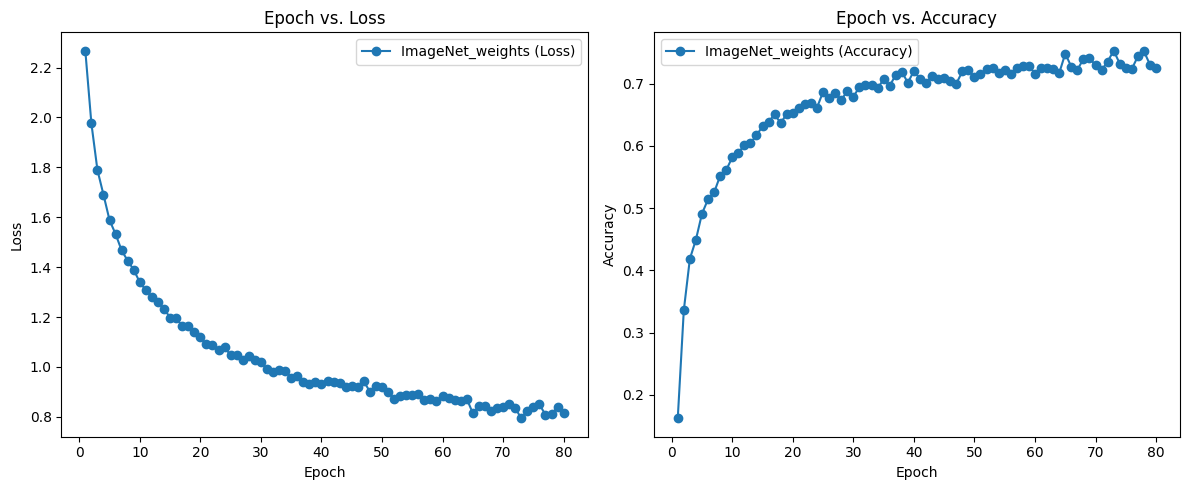

In [25]:
Imagenet_model = timm.create_model('efficientnet_b0', pretrained=True)      #default EffecientNet weights trained on Imagenet data 

# Modify the last fully connected layer for CIFAR-10 (10 classes)
num_classes = 10
Imagenet_model.classifier = nn.Linear(Imagenet_model.classifier.in_features, num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Imagenet_model.classifier.parameters(), lr=0.001, weight_decay = 0.001)
num_epochs = 80

Imagenet_model, loss_list_1, accuracy_list_1 = train_model(Imagenet_model, train_loader, criterion, optimizer, num_epochs = num_epochs)
accuracy_1, average_loss_1 =  validate_model(Imagenet_model, test_loader, criterion)

plot_losses_and_accuracy([loss_list_1],[accuracy_list_1], ['ImageNet_weights'])


## Using Jigsaw Weights

Here we will use Jigsaw Puzzle weights.

100%|██████████████████████████████████████████████████████████| 80/80 [02:39<00:00,  2.00s/it, accuracy=0.296, loss=2]


Validation Accuracy: 18.71%, Average Loss: 2.3069


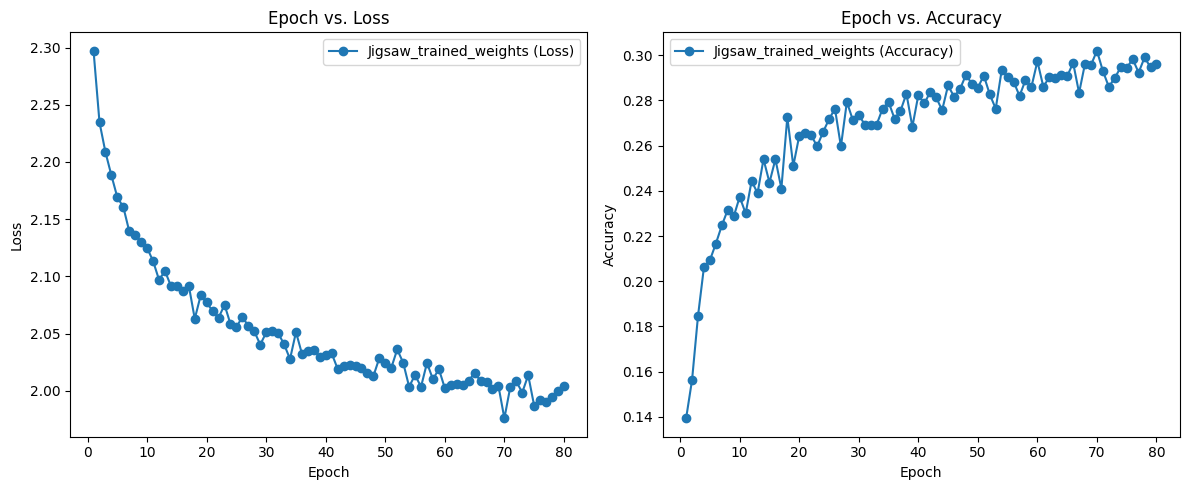

In [42]:
Jigsaw_model = timm.create_model('efficientnet_b0', pretrained=False)  # Set pretrained to False
in_features = Jigsaw_model.classifier.in_features
Jigsaw_model = nn.Sequential(*(list(Jigsaw_model.children())[:-1]))

checkpoint = torch.load(conv_file)
Jigsaw_model.load_state_dict(checkpoint)

num_classes = 10
Jigsaw_model.add_module('classifier' , nn.Linear(in_features, num_classes))


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Jigsaw_model.classifier.parameters(), lr=0.001, weight_decay = 0.001)
num_epochs = 80

Jigsaw_model, loss_list_2, accuracy_list_2 = train_model(Jigsaw_model, train_loader, criterion, optimizer, num_epochs = num_epochs)
accuracy_2, average_loss_2 =  validate_model(Jigsaw_model, test_loader, criterion)
plot_losses_and_accuracy([loss_list_2],[accuracy_list_2], ['Jigsaw_trained_weights'])

## Analysis

On comparing losses we can see the imagenet model converges to a much lower loss of 0.78 wheras the Jigsaw model coverges at loss of 2. The acuracy results 

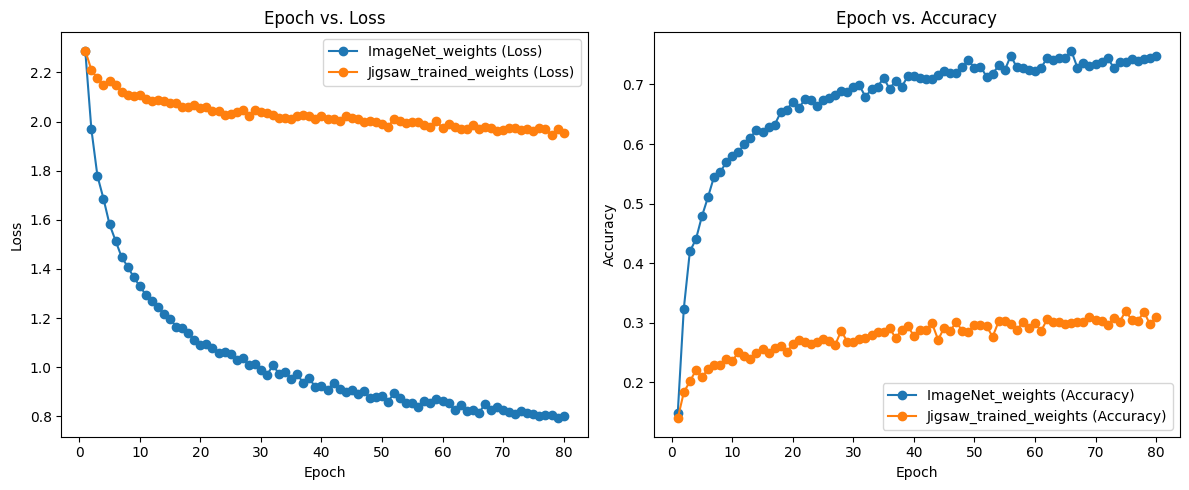

In [90]:
plot_losses_and_accuracy([loss_list_1, loss_list_2], [accuracy_list_1, accuracy_list_2], ['Supervised','CFN'])

In [40]:
print('Imagenet_model: ')
accuracy_1, average_loss_1 =  validate_model(Imagenet_model, test_loader, criterion)
print('Jigsaw_model: ')
accuracy_2, average_loss_2 =  validate_model(Jigsaw_model, test_loader, criterion)

Imagenet_model: 
Validation Accuracy: 29.74%, Average Loss: 2.4690
Jigsaw_model: 
Validation Accuracy: 18.44%, Average Loss: 2.3246


The accuracy results show that jigsaw model is close to the supervised model with an accuracy difference of 11%. Precision and Recall metrics also shows a similar trend.

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import torch
from torchvision import transforms
from torch.utils.data import DataLoader


def evaluate_model(model, test_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')

    return precision, recall


imagnet_model = Imagenet_model
jigsaw_model = Jigsaw_model  

# Evaluate both models
imagnet_precision, imagnet_recall = evaluate_model(imagnet_model, test_loader)
jigsaw_precision, jigsaw_recall = evaluate_model(jigsaw_model, test_loader)

# Print precision and recall for both models
print('Imagnet Model:')
print(f'Precision: {imagnet_precision:.4f}, Recall: {imagnet_recall:.4f}')

print('Jigsaw Model:')
print(f'Precision: {jigsaw_precision:.4f}, Recall: {jigsaw_recall:.4f}')



Imagnet Model:
Precision: 0.2963, Recall: 0.2974
Jigsaw Model:
Precision: 0.1806, Recall: 0.1844


## Conclusion

The Image Jigsaw Puzzle is a very useful and accurate SSL method. Here we had trained the model with 20 puzzle per image and for just 4 epochs which took aprox. 2.5 hours to complete. Accuracy was close to Supervised learning model. The accuracy could be further increased by more number of puzzles per image and increasing the number of epochs. 